# Experiment: Million Songs Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,RidgeCV
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F


df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
tt=463715
ee=51630
train=df.iloc[:tt] 
test=df.iloc[tt:] 

train_y = train[0]
test_y = test[0] #response:year
train_x = train
test_x = test
del train_x[0]
del test_x[0]
total_x=pd.concat([train_x,test_x])
x=preprocessing.StandardScaler().fit(total_x).transform(total_x) #normalize
x=pd.DataFrame(x)
train_x=x.iloc[:tt]
test_x=x.iloc[tt:]

train_x.reset_index(drop=True, inplace=True) 
test_x.reset_index(drop=True, inplace=True) 
train_y.reset_index(drop=True, inplace=True) 
test_y.reset_index(drop=True, inplace=True) 

train_x ##display the data

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,1.080575,0.391265,1.826532,0.464657,-0.474730,-0.278204,-1.552371,-1.310845,0.387704,-0.666166,...,-0.085335,0.108508,0.142775,-0.237355,0.049233,-0.356182,0.544458,-0.470599,-0.255977,0.042292
1,0.880919,0.332292,1.748539,0.721828,-0.164945,-1.191173,0.765681,0.109626,1.420941,0.414950,...,-0.314250,0.306236,-0.069483,0.052017,-0.632328,-0.436057,0.556448,0.568744,0.206940,1.158587
2,1.247622,0.592600,1.337173,0.750657,-0.001110,-0.702100,-0.060914,-0.069956,1.166254,-0.074608,...,-0.396186,0.566683,-0.756534,-0.284019,-0.024220,0.223128,-0.509789,-0.338457,0.105819,-0.090208
3,0.801044,-0.061805,0.783683,0.087218,0.329180,-1.298429,0.510714,-1.073355,-0.016803,-1.262655,...,0.586237,-0.559427,-0.478689,-0.890161,-0.793906,0.567269,-0.263107,0.408116,0.967862,0.793384
4,1.249775,0.793334,1.657037,0.447460,-0.406775,-0.567138,-0.692498,-0.952197,0.841844,-0.144910,...,-0.181585,0.099672,0.191319,-0.585576,-0.111877,-0.219960,0.448804,0.256882,0.192038,1.241363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463710,0.493427,-0.336316,-0.084681,-0.658594,-1.673199,0.282011,-1.493945,-0.686837,0.831008,-1.058139,...,0.124247,0.991760,-0.324729,-0.395601,1.531331,0.085218,-0.001498,-0.322949,-0.616705,-0.697774
463711,-0.124812,0.200480,-0.926193,-0.897601,-1.643501,-0.375450,0.622636,-0.478409,0.758789,-1.016975,...,-0.372135,1.868488,-0.549899,-0.652146,2.410029,0.030487,-1.189134,-0.120523,0.468067,-0.343264
463712,0.162997,0.006509,0.836644,0.067344,-0.367053,0.273406,-2.079877,-0.029351,-0.221383,-0.722086,...,-0.103120,0.440416,-0.406601,-0.822279,0.864693,-0.687515,-0.265901,-0.663702,0.012903,-0.246192
463713,0.247234,0.249282,-0.407312,-1.278516,-2.290479,-0.373539,-0.105010,0.164208,-0.146179,0.030704,...,0.367180,1.480824,0.126993,-0.701360,1.256892,0.637414,0.344071,0.532877,0.466592,0.700802


In [2]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len

## 1. DNN

In [4]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=1024, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=1024,shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(90, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
print(device)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
dnn_trainloss=[]
dnn_testloss=[]
t0=time.time()
#tb=0
#tc=0

for epoch in range(20): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        #print(x.shape,y.shape,x.device, y.device,net.fc1.weight.device)
        #td=time.time()-tc 
        #ta=time.time()
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
        #print(tb/(tb+td))
        #tb=time.time()-ta
        #tc=time.time()

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>5 and float(test_loss)>max(dnn_testloss[-5:-1]):
        break
    
    if epoch % 2 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    
    dnn_trainloss.append(float(train_loss))
    dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=90, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)
cpu
epoch 0
            Train set - loss: 756400.875
            Test  set - loss: 739168.6875
            
epoch 2
            Train set - loss: 20947.265625
            Test  set - loss: 18800.251953125
            
epoch 4
            Train set - loss: 1072.22509765625
            Test  set - loss: 890.6712036132812
            
epoch 6
            Train set - loss: 294.0543212890625
            Test  set - loss: 398.8669738769531
            
epoch 8
            Train set - loss: 235.96817016601562
            Test  set - loss: 378.2474670410156
            
epoch 10
            Train set - loss: 209.79269409179688
            Test  set - loss: 376.4117736816406
            
epoch 12
            Train set - loss: 210.08470153808594
    

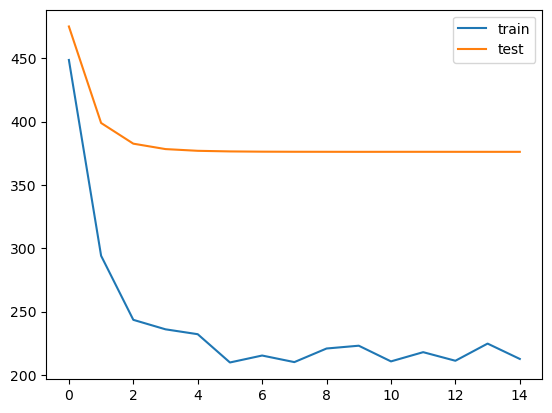

In [5]:
plt.plot(dnn_trainloss[5:])
plt.plot(dnn_testloss[5:])
plt.legend(["train","test"])

## 2. Resnet

In [6]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=1024, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=1024, shuffle=False)

class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(infeatures,outfeatures)
    
    def forward(self, x):
        y = self.fc1(x)
        y= F.relu(y)
        x = self.fc2(x)
        return F.relu(x+y)


class ResNet(nn.Module): 
    def __init__(self):
        super(ResNet, self).__init__()
        self.rblock1 = ResidualBlock(90,256)
        self.rblock2 = ResidualBlock(256,128)
        self.rblock3 = ResidualBlock(128,64)
        self.fc4 = nn.Linear(64,1)
    
 
    def forward(self, x):
        x = self.rblock1(x)
        x = self.rblock2(x)
        x = self.rblock3(x)
        return self.fc4(x)
#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=0.1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ResNet()
net = net.to(device)
torch.manual_seed(0)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-4,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)
res_trainloss=[]
res_testloss=[]
t0=time.time()
for epoch in range(20): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()

    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)
    
        test_loss = criterion(y_test_pred,y)
    
    if epoch>5 and float(test_loss)>max(res_testloss[-5:-1]):
        break
    
    if epoch % 2 == 0:        
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    res_trainloss.append(float(train_loss))
    res_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("ResNet complexity and model fitted in %.3f s" % dnn_fit)

ResNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=90, out_features=256, bias=True)
    (fc2): Linear(in_features=90, out_features=256, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (fc2): Linear(in_features=256, out_features=128, bias=True)
  )
  (rblock3): ResidualBlock(
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (fc2): Linear(in_features=128, out_features=64, bias=True)
  )
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 558444.125
            Test  set - loss: 543718.4375
            
epoch 2
            Train set - loss: 15939.4345703125
            Test  set - loss: 13977.3974609375
            
epoch 4
            Train set - loss: 902.9437866210938
            Test  set - loss: 764.0151977539062
            
epoch 6
            Train set - loss: 278.7446594238281
            Test  set - loss: 394.35369873046875
            
e

# 3. new

In [9]:
def sample_1d(pdf, gamma, device):
    if pdf == 'G':
        w = torch.randn(1, device=device) * gamma
        return w
    elif pdf == 'L':
        w = torch.distributions.laplace.Laplace(torch.tensor([0.0], device=device), torch.tensor([1.0], device=device)).sample() * gamma
        return w
    elif pdf == 'C':
        w = torch.distributions.cauchy.Cauchy(torch.tensor([0.0], device=device), torch.tensor([1.0], device=device)).sample() * gamma
        return w
    
def sample(pdf, gamma, d, device):
    return torch.tensor([sample_1d(pdf, gamma, device) for _ in range(d)], device=device)

class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : shape (D,d)
    b : shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    """
    
    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1, device='cpu'):
        self.d = d
        self.D = D
        self.gamma = gamma
        self.device = device

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    
    
    def create(self):
        """Create a d->D fourier random feature"""
        self.b = torch.rand(self.D, device=self.device) * 2 * torch.pi
        self.W = sample(self.kernel, self.gamma, self.d * self.D, self.device).reshape(self.D, self.d)

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : (shape=(n,d))
            to transform; must be single dimension vector
        Returns
        -------
        x : (shape=(n,D))
            Feature space transformation of x
        """
        #print(self.W.shape,self.b.reshape(-1,1).shape,x.shape)
        #print((self.W @ x.T).shape)
       

        result = torch.sqrt(torch.tensor([2.0 / self.D], device=x.device)) * torch.cos(
            self.W @ x.T + (self.b.reshape(-1, 1) @ torch.ones((1,len(x)), device=x.device))
        )
        return result.T
    

In [21]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=1024, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=1024, shuffle=False)

rff0=RandomFourierFeature(90,256,kernel='C',gamma=0.02)
rff1=RandomFourierFeature(128,128,kernel='G',gamma=0.1)
rff2=RandomFourierFeature(64,64,kernel='G',gamma=0.5)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = rff0.transform(x)
        x=self.fc1(x)
        x = rff1.transform(x)
        x=self.fc2(x)
        x = rff2.transform(x)
        return self.fc3(x)


#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
torch.manual_seed(1)
net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=5e-5,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]
t0 = time.time()
for epoch in range(20): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>5 and float(test_loss)>max(kernelnn_testloss[-5:-1]):
        break
    
    
    if epoch % 2 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
   
    kernelnn_trainloss.append(float(train_loss))
    kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 1622537.875
            Test  set - loss: 1607737.5
            
epoch 2
            Train set - loss: 249715.890625
            Test  set - loss: 241782.375
            
epoch 4
            Train set - loss: 2375.78759765625
            Test  set - loss: 1864.0576171875
            
epoch 6
            Train set - loss: 173.62278747558594
            Test  set - loss: 408.0314025878906
            
epoch 8
            Train set - loss: 124.6273193359375
            Test  set - loss: 361.9786071777344
            
epoch 10
            Train set - loss: 123.11907196044922
            Test  set - loss: 368.41131591796875
            
epoch 12
            Train set - loss: 121.05491638183594
            Test  set - loss: 341.9067077636719
            
epoch 14

# 4. new

In [11]:
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=1024, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=1024, shuffle=False)

rff0=RandomFourierFeature(90,256,kernel='C',gamma=0.02)
rff1=RandomFourierFeature(128,128,kernel='G',gamma=0.1)
rff2=RandomFourierFeature(64,64,kernel='G',gamma=0.5)


class ResidualBlock(nn.Module):
    def __init__(self,infeatures,outfeatures,rff):
        super(ResidualBlock,self).__init__()
        self.infeatures = infeatures
        self.outfeatures = outfeatures
        self.rff=rff
        
        self.fc1 = nn.Linear(infeatures,outfeatures)
        self.fc2 = nn.Linear(outfeatures,outfeatures)
    
    def forward(self, x):
        rff=self.rff
        x = self.fc1(x)
        y = rff.transform(x)
        y = self.fc2(y)
        return x+y

class ResKernelNet(nn.Module): 
    def __init__(self):
        super(ResKernelNet, self).__init__()
        self.rblock1 = ResidualBlock(256,128,rff1)
        self.rblock2 = ResidualBlock(128,64,rff2)
        self.fc3 =nn.Linear(64,1)
 
    def forward(self, x):
        x = rff0.transform(x)
        x = self.rblock1(x)
        x = self.rblock2(x)
        return self.fc3(x)

#initialize
def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.normal_(m.weight,mean=0,std=0.5)
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,a=0,b=1)
        m.bias.data.fill_(0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ResKernelNet()
net = net.to(device)
torch.manual_seed(1)
#net.apply(init_weights)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=1e-6,momentum=0.9,weight_decay=1e-2) #optim.Adam(...)

loss=[]
reskernel_trainloss=[]
reskernel_testloss=[]
t0 = time.time()
for epoch in range(20): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_test_pred = net(x)
        y_test_pred = torch.squeeze(y_test_pred)

        test_loss = criterion(y_test_pred,y)
            
    if epoch>5 and float(test_loss)>max(reskernel_testloss[-5:-1]):
        break
    
    
    if epoch % 2 == 0:         
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
    reskernel_trainloss.append(float(train_loss))
    reskernel_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("Residual KernelNet complexity and model fitted in %.3f s" % dnn_fit)

ResKernelNet(
  (rblock1): ResidualBlock(
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
  )
  (rblock2): ResidualBlock(
    (fc1): Linear(in_features=128, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 115.25847625732422
            Test  set - loss: 433.5244445800781
            
epoch 2
            Train set - loss: 110.26060485839844
            Test  set - loss: 423.6630554199219
            
epoch 4
            Train set - loss: 111.69669342041016
            Test  set - loss: 433.60968017578125
            
epoch 6
            Train set - loss: 115.14805603027344
            Test  set - loss: 412.3328552246094
            
epoch 8
            Train set - loss: 104.0451431274414
            Test  set - loss: 403.60015869140625
            
epoch 10
        

In [22]:
print(dnn_testloss[-1],res_testloss[-1],kernelnn_testloss[-1],reskernel_testloss[-1])

376.08343505859375 376.1024475097656 347.1639404296875 351.1676940917969
